## Prepare data for fasttext model

In [219]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext
from collections import Counter
import spacy
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/analekseev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Готовим метки для классификации

In [8]:
hpac_train = pd.read_csv('hpac_corpus/hpac_training_128.tsv', sep='\t', header=None)
spells2target = {spell:num for num, spell in enumerate(hpac_train[1].unique())}

In [9]:
hpac_train

,0,1,2
0,7642954.0.676,RIDDIKULUS,were staring at her . she was up next to face ...
1,10443333.0.5753,RIDDIKULUS,"that whole time . her first reaction , for whi..."
2,4703706.0.8690,STUPEFY,we watched his inglorious withdrawal together ...
3,4593427.0.1815,ACCIO,"my wand , `` incendio . '' this wretched chill..."
4,4278446.0.2692,EXPELLIARMUS,"already compared ours , they 're the same ever..."
...,...,...,...
60975,2790536.0.136,CRUCIO,", evenly matched . good against evil . light a..."
60976,7553216.0.1500,ACCIO,the professor then turned and walked into the ...
60977,2721339.0.1040,DIFFINDO,ran through the crowd below . she felt her eye...
60978,2569402.0.4724,INCENDIO,ministry a decade ago . they recorded his thou...


Отфильтровали стоп-слова и выкинули небуквенные символы

In [16]:
st_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

In [19]:
def clean(sentence):
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in st_words and len(w) > 1]
    cleaned_sentence = ' '.join(filtered_words)
    return cleaned_sentence

In [20]:
hpac_train['cleaned_sentence'] = hpac_train[2].apply(clean)
hpac_train['target'] = hpac_train[1].map(spells2target)

Сохраняем данные в файл в том виде, в котором fasttext сможет использовать их для обучения

In [47]:
def save_to_file(name, source):
    with open(name+'.txt', 'w+') as f:
        for sent, targ in zip(source['cleaned_sentence'], source['target']):
            f.write('__label__'+str(targ))
            f.write(' ')
            f.write(sent)
            f.write('\n')

In [48]:
save_to_file('hpac_training_128', hpac_train)

In [43]:
hpac_dev = pd.read_csv('hpac_corpus/hpac_dev_128.tsv', sep='\t', header=None)

In [44]:
hpac_dev['cleaned_sentence'] = hpac_dev[2].apply(clean)
hpac_dev['target'] = hpac_dev[1].map(spells2target)

In [45]:
hpac_dev

,0,1,2,cleaned_sentence,target
0,10873161.0.5925,PROTEGO,could do . kingsley vanished the chair that ro...,could kingsley vanished chair ronald sat erect...,4
1,7657727.0.5782,STUPEFY,"student in the castle , and she 'll be damned ...",student castle damned runs away leaves loves w...,1
2,2981611.0.971,ACCIO,"regulus black '' `` well , at least he has a s...",regulus black well least sense humor sirius re...,2
3,8409475.0.5941,ACCIO,outside on the quidditch pitch or near the lak...,outside quidditch pitch near lake belief remai...,2
4,2082596.0.429,CRUCIO,for them . slowly his happiness drains away du...,slowly happiness drains away lesson father lec...,6
...,...,...,...,...,...
7600,4833934.0.1713,REPARO,"she sank back onto the ground , feeling weak a...",sank back onto ground feeling weak undone tear...,40
7601,12665066.0.301,NOX,greyback . greyback started to advance towards...,greyback greyback started advance towards siri...,43
7602,6377162.0.13175,SONORUS,rescued all of the people who were underwater ...,rescued people underwater prevented contestant...,20
7603,12375286.0.18091,HOMENUM_REVELIO,to get up sirius cast a quick sleeping charm a...,get sirius cast quick sleeping charm placed st...,58


In [49]:
save_to_file('hpac_dev_128', hpac_dev)

## Train Fasttext model

Далее обучаем модель, смотрим метрики качества

In [507]:
model = fasttext.train_supervised(input='hpac_training_128.txt', lr=0.5, epoch=50, wordNgrams=5, dim=100, loss='ova')

In [509]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('hpac_dev_128.txt'))

N	7605
P@1	0.335
R@1	0.335


In [510]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('lemmas_hpac_dev_128.txt'))

N	7605
P@1	0.296
R@1	0.296


In [126]:
r = model.predict(hpac_dev['cleaned_sentence'].tolist())

In [127]:
def unlabel(str_label):
    return int(re.sub("[^0-9]", "", str_label))

In [128]:
pred = []
for i in r[0]:
    pred.append(unlabel(i[0]))

In [129]:
accuracy_score(hpac_dev['target'], pred)

0.3351742274819198

In [134]:
f1_score(hpac_dev['target'], pred, average='micro')

0.3351742274819198

In [135]:
precision_score(hpac_dev['target'], pred, average='micro')

0.3351742274819198

In [136]:
recall_score(hpac_dev['target'], pred, average='micro')

0.3351742274819198

In [190]:
cm = confusion_matrix(hpac_dev['target'], pred, normalize='true')

Строим матрицу ошибок

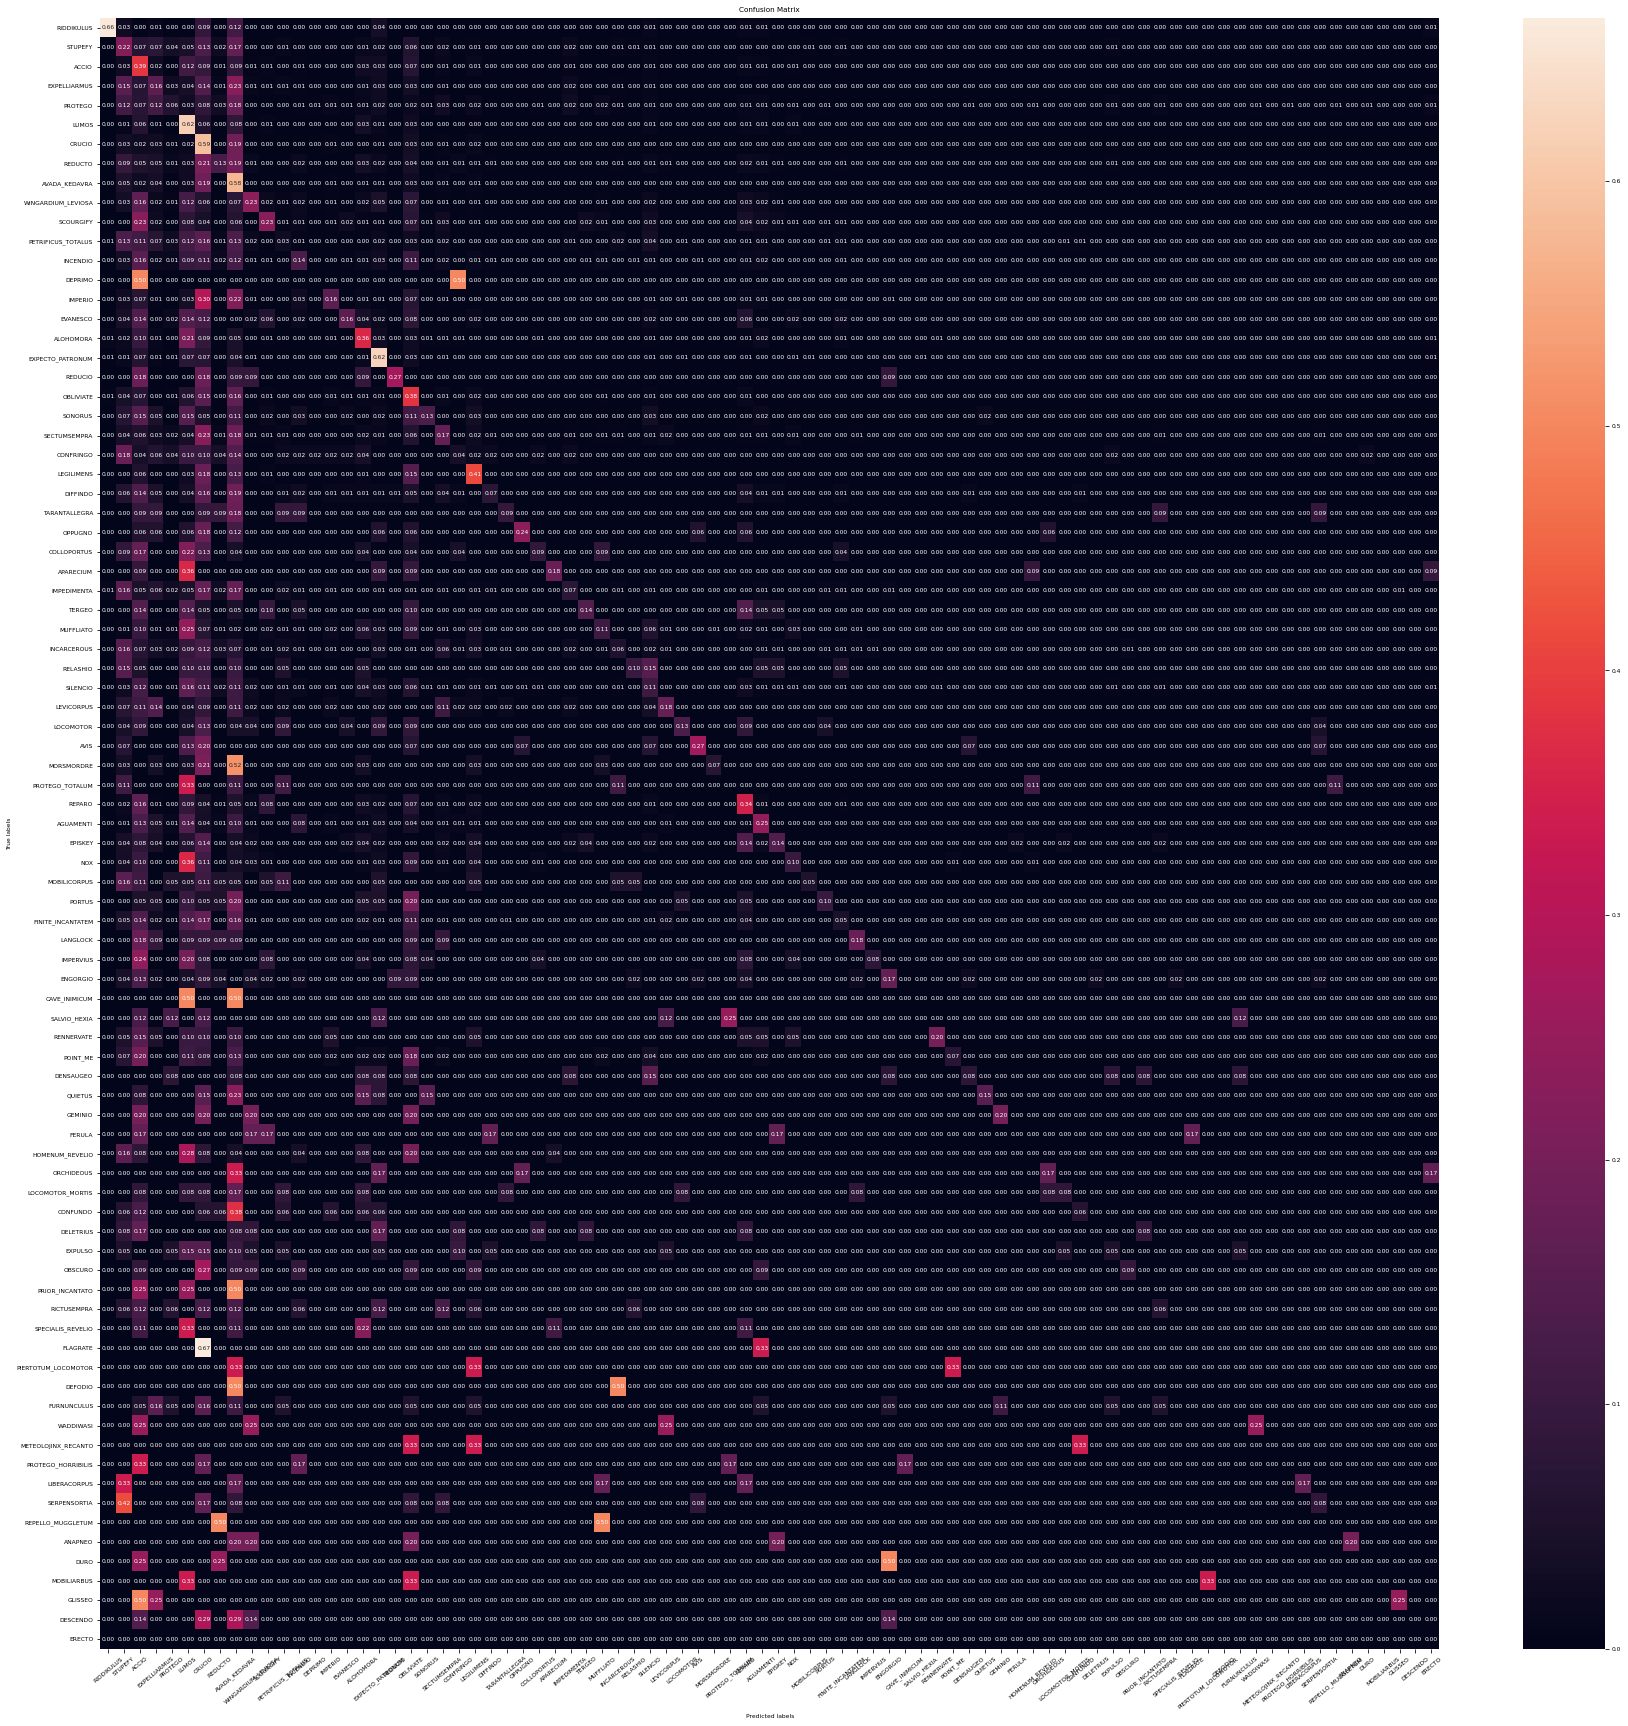

In [192]:
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 6})
ax= plt.subplot()
sns.heatmap(cm, ax = ax, annot=True, fmt='.2f')


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(spells2target.keys(), rotation=40)
ax.set_yticklabels(spells2target.keys(), rotation=0)
plt.savefig('cm.png', dpi=300)
plt.show()

## Find most frequent and less frequent classes in dev set

In [195]:
spell_freq = Counter(hpac_dev[1]) 

In [196]:
spell_freq.most_common(10)

[('AVADA_KEDAVRA', 928),
 ('CRUCIO', 865),
 ('ACCIO', 549),
 ('LUMOS', 473),
 ('STUPEFY', 421),
 ('OBLIVIATE', 356),
 ('EXPELLIARMUS', 337),
 ('LEGILIMENS', 213),
 ('EXPECTO_PATRONUM', 200),
 ('SECTUMSEMPRA', 179)]

In [198]:
spell_freq.most_common()[-10:]

[('DURO', 4),
 ('PRIOR_INCANTATO', 4),
 ('METEOLOJINX_RECANTO', 3),
 ('FLAGRATE', 3),
 ('PIERTOTUM_LOCOMOTOR', 3),
 ('MOBILIARBUS', 3),
 ('REPELLO_MUGGLETUM', 2),
 ('DEPRIMO', 2),
 ('DEFODIO', 2),
 ('CAVE_INIMICUM', 2)]

## Let try to use lemmatization on our corpus
Приводим кажлое слово к начальной форме.   
И повторяем предыдущий пункт 

In [200]:
nlp = spacy.load("en_core_web_md")

In [206]:
def lemma(sentence):
    doc = nlp(sentence)
    filtered_words = [w.lemma_ for w in doc]
    lemmatized_sentence = ' '.join(filtered_words)
    return lemmatized_sentence

In [210]:
hpac_train['lemma'] = hpac_train['cleaned_sentence'].apply(lemma)
hpac_dev['lemma'] = hpac_dev['cleaned_sentence'].apply(lemma)

In [211]:
def save_to_file_lemmas(name, source):
    with open(name+'.txt', 'w+') as f:
        for sent, targ in zip(source['lemma'], source['target']):
            f.write('__label__'+str(targ))
            f.write(' ')
            f.write(sent)
            f.write('\n')

In [444]:
save_to_file_lemmas('lemmas_hpac_training_128', hpac_train)
save_to_file_lemmas('lemmas_hpac_dev_128', hpac_dev)

In [496]:
lemma_model = fasttext.train_supervised(input='lemmas_hpac_training_128.txt', lr=0.5, epoch=50, wordNgrams=5, dim=100, loss='ova')

In [497]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*lemma_model.test('lemmas_hpac_dev_128.txt'))

N	7605
P@1	0.336
R@1	0.336


In [432]:
r = lemma_model.predict(hpac_dev['lemma'].tolist())
pred = []
for i in r[0]:
    pred.append(unlabel(i[0]))
    
cm = confusion_matrix(hpac_dev['target'], pred, normalize='true')

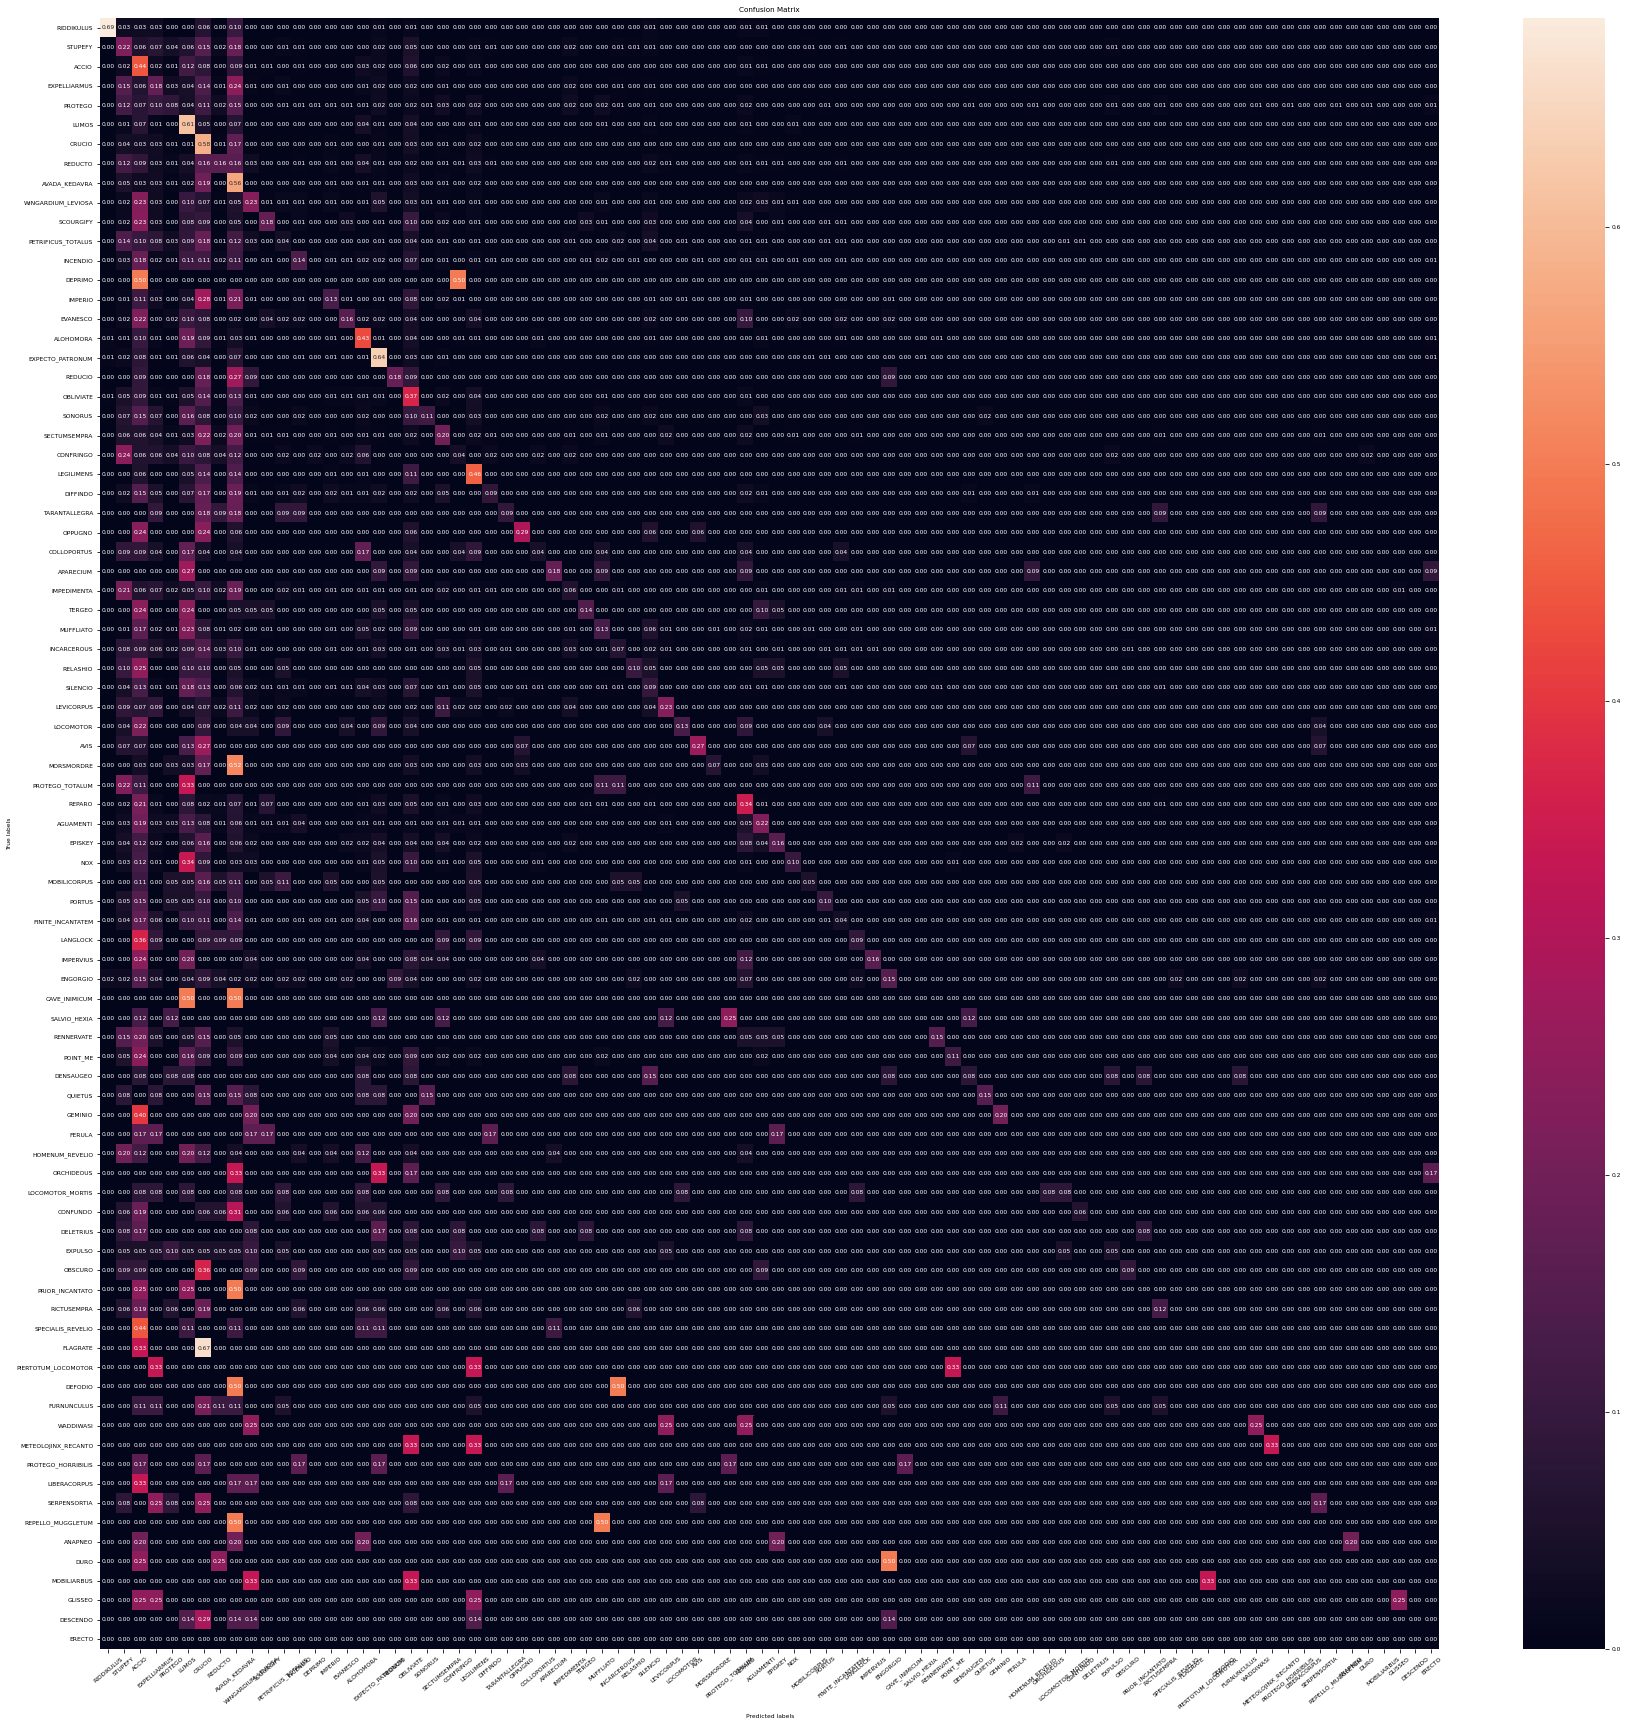

In [433]:
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 6})
ax= plt.subplot()
sns.heatmap(cm, ax = ax, annot=True, fmt='.2f')


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(spells2target.keys(), rotation=40)
ax.set_yticklabels(spells2target.keys(), rotation=0)
plt.savefig('fasttext_lemma_cm.png', dpi=300)
plt.show()

## Lets try to use synonyms to augment our data for train set

Выбираем случайные слова, с вероятностью 0.4 заменяем их на синонимы с помощью предобученной модели WordNet, чтобы увеличить обучающий набор в 2 раза. 

In [512]:
def augment_w_syn(sentence, th = 0.6):
    words = sentence.split()
    is_change = np.random.rand(len(words)) > th
    new_words = []
    for i, w in enumerate(words):
        if is_change[i]:
            sets = wn.synsets(w)
            if not len(sets):
                continue
            synset = np.random.choice(sets)
            n_w = np.random.choice(synset.lemmas()).name().lower().split('_')
            if isinstance(n_w, list):
                new_words += n_w
            else:
                new_words.append(n_w)
        else:
            new_words.append(w)
    return ' '.join(new_words)

In [513]:
hpac_train['augment'] = hpac_train['lemma'].apply(augment_w_syn)

In [514]:
def save_to_file_augment(name, source):
    with open(name+'.txt', 'w+') as f:
        for sent, targ, aug in zip(source['lemma'], source['target'], source['augment']):
            f.write('__label__'+str(targ))
            f.write(' ')
            f.write(sent)
            f.write('\n')
            f.write('__label__'+str(targ))
            f.write(' ')
            f.write(aug)
            f.write('\n')

In [515]:
save_to_file_augment('aug_hpac_training_128', hpac_train)

In [516]:
aug_model = fasttext.train_supervised(input='aug_hpac_training_128.txt', lr=0.5, epoch=50, wordNgrams=5, dim=150, loss='ova')

In [517]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*aug_model.test('lemmas_hpac_dev_128.txt'))

N	7605
P@1	0.341
R@1	0.341


In [518]:
r = aug_model.predict(hpac_dev['lemma'].tolist())
pred = []
for i in r[0]:
    pred.append(unlabel(i[0]))
    
cm = confusion_matrix(hpac_dev['target'], pred, normalize='true')

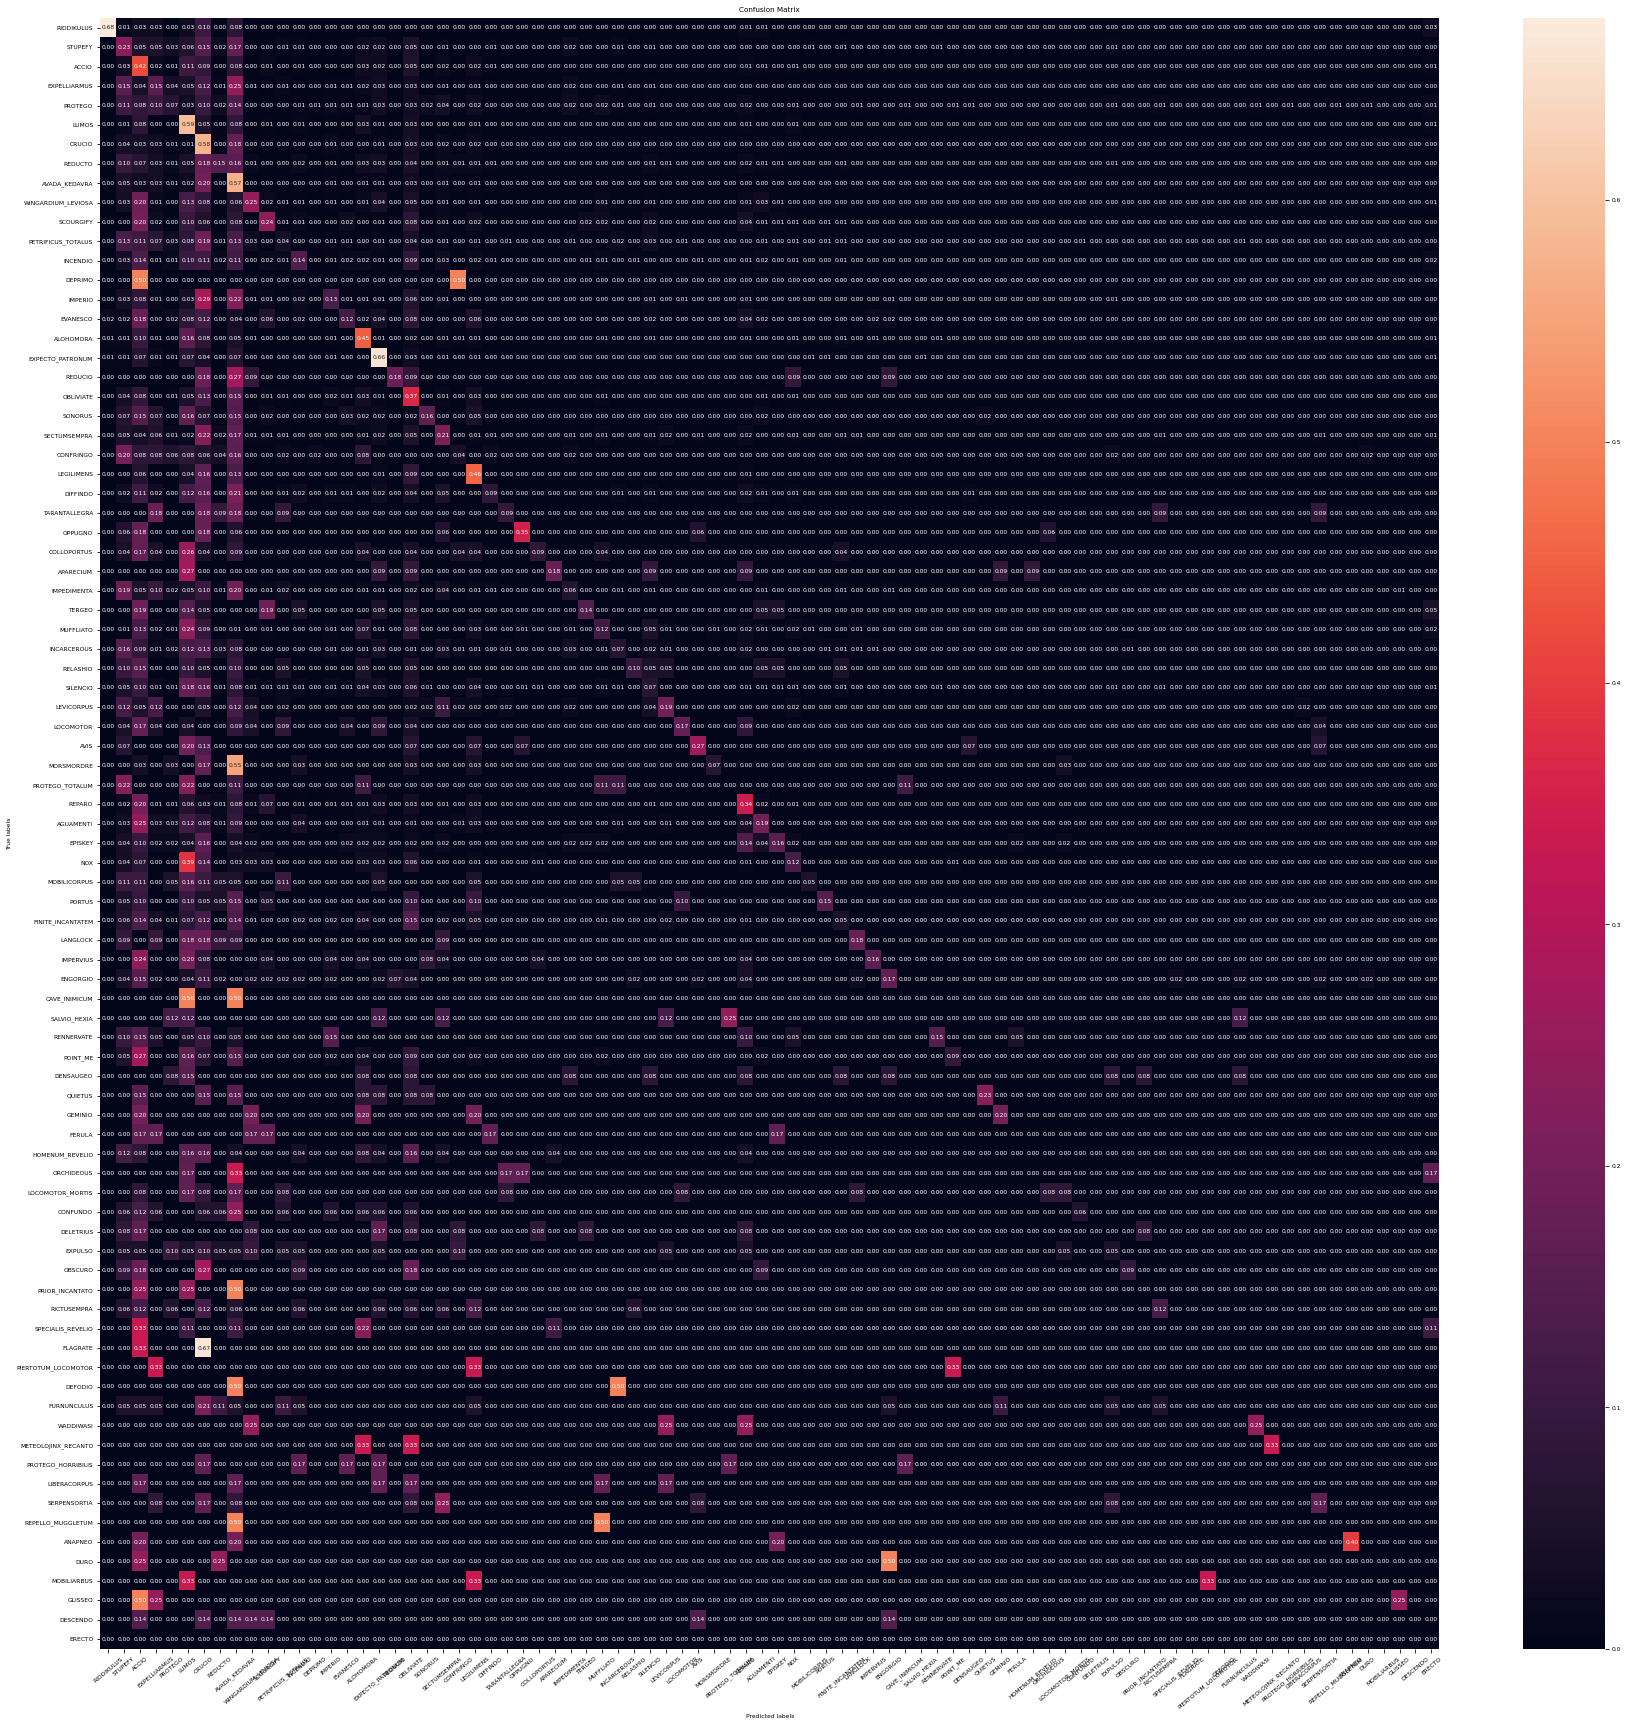

In [519]:
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 6})
ax= plt.subplot()
sns.heatmap(cm, ax = ax, annot=True, fmt='.2f')


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(spells2target.keys(), rotation=40)
ax.set_yticklabels(spells2target.keys(), rotation=0)
plt.savefig('fasttext_aug_cm.png', dpi=300)
plt.show()

# Now check testset

И, конечно, в добавок ко всем промежуточным проверкам, устраиваем финальную проверку на тестовм наборе!

In [436]:
hpac_test = pd.read_csv('hpac_corpus/hpac_test_128.tsv', sep='\t', header=None)

In [437]:
hpac_test['cleaned_sentence'] = hpac_test[2].apply(clean)
hpac_test['target'] = hpac_test[1].map(spells2target)
hpac_test['lemma'] = hpac_test['cleaned_sentence'].apply(lemma)

In [520]:
final_test_results = aug_model.predict(hpac_test['lemma'].tolist())
final_pred = []
for i in final_test_results[0]:
    final_pred.append(unlabel(i[0]))
    
final_cm = confusion_matrix(hpac_test['target'], final_pred, normalize='true')

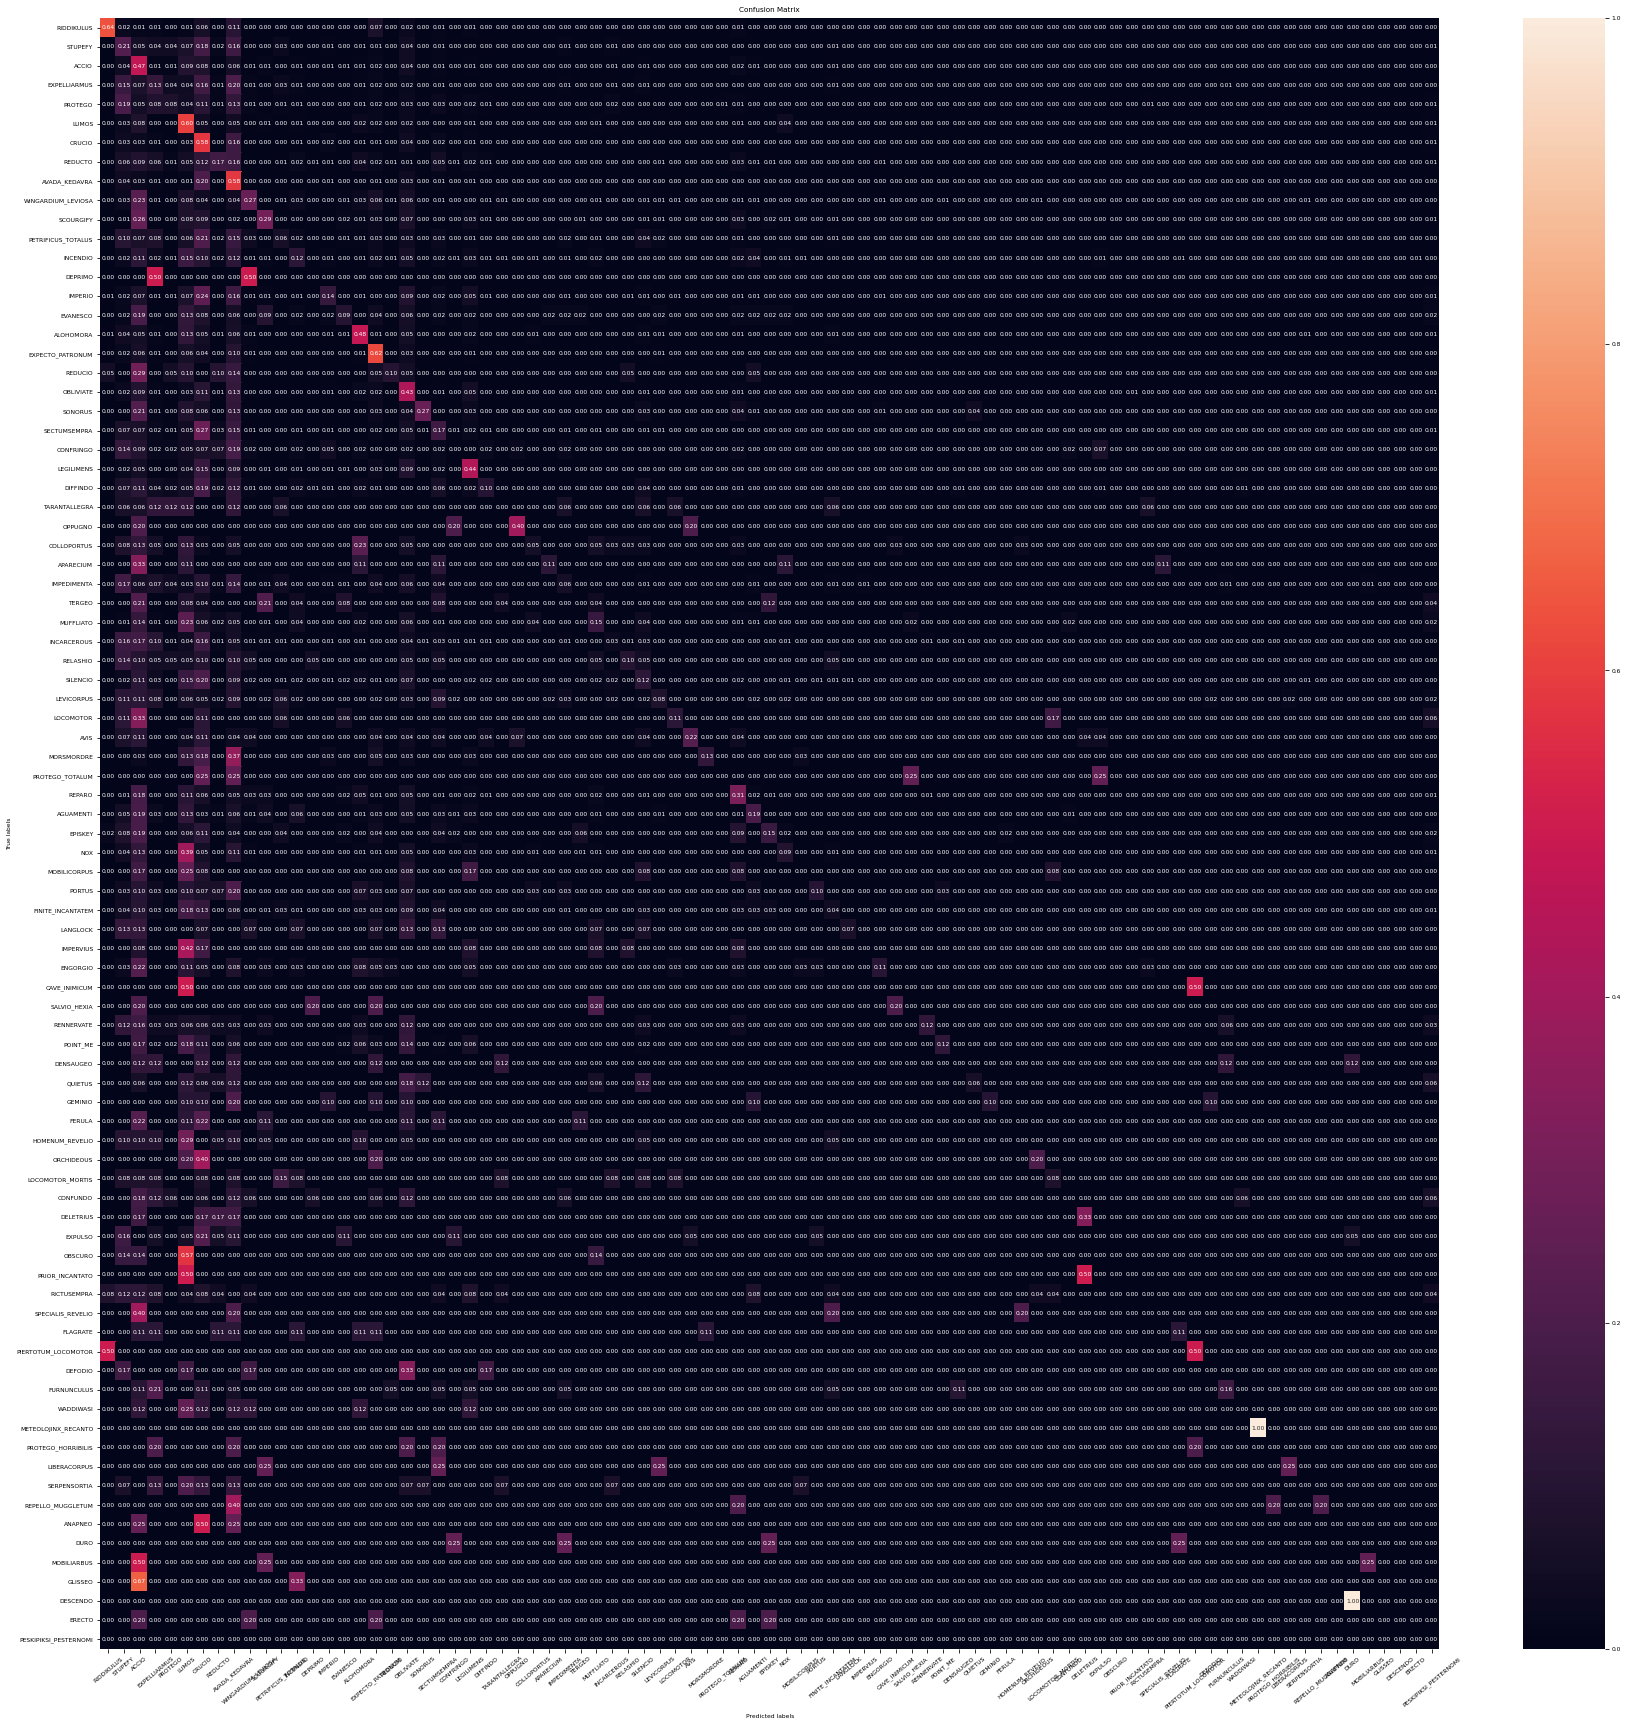

In [521]:
plt.figure(figsize=(30,30))
plt.rcParams.update({'font.size': 6})
ax= plt.subplot()
sns.heatmap(final_cm, ax = ax, annot=True, fmt='.2f')


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(spells2target.keys(), rotation=40)
ax.set_yticklabels(spells2target.keys(), rotation=0)
plt.savefig('fasttext_final_cm.png', dpi=300)
plt.show()

In [522]:
f1_score(hpac_test['target'], final_pred, average='micro')

0.34835265008464644

# Check on our models

In [498]:
save_to_file_lemmas('lemmas_hpac_test_128', hpac_test)

In [511]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*model.test('lemmas_hpac_test_128.txt'))

N	7679
P@1	0.313
R@1	0.313


In [505]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*lemma_model.test('lemmas_hpac_test_128.txt'))

N	7679
P@1	0.349
R@1	0.349


In [523]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

print_results(*aug_model.test('lemmas_hpac_test_128.txt'))

N	7679
P@1	0.348
R@1	0.348
